I'll use this notebook to implement and test a numerical tool for converting from action-angle coordinates to Cartesian coordinates.

In [1]:
# import packages
import numpy as np
import scipy.integrate as integrate
import scipy.misc
import time

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation

from matplotlib import cm
from matplotlib.ticker import LinearLocator
## set default plot size
plt.rcParams["figure.figsize"] = (10, 7)
## set global font size
plt.rcParams.update({'font.size':14})

import astropy.units as u
from astropy import constants as const

import scipy.integrate as integrate 
import scipy.optimize as optimize

# Step 1: Derive $J(E)$

In [2]:
## define Phi, positive v_z, and J(E)
def Phi(z):
    '''
    Represents the (dimensionless) slab potential.
    
    '''
    
    return 2 * np.log(np.cosh(z / 2))

def v_z_positive(z, E):
    '''
    Represents the (positive) v_z corresponding to a given z and E; i.e.,
    v_z = +sqrt[2*(E-Phi(z))]. 
    
    '''
    
    return np.sqrt(2*(E-Phi(z)))

def one_over_v_z_positive(z, E):
    '''
    Represents 1/v_z.
    
    '''
    
    return 1 / np.sqrt(2*(E-Phi(z)))

def J_E(E): 
    '''
    Returns the numerical value of J corresponding to a given energy E.
    
    '''
    
    z_max = 2 * np.arccosh( np.exp(E/2) )
    return (2 / np.pi) * integrate.quad(v_z_positive, 0, z_max, args=(E))[0]

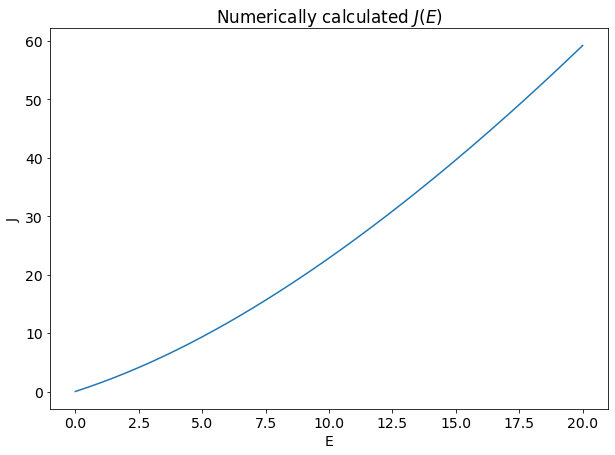

In [3]:
E_step = 0.1
Es = np.arange(0., 20+E_step, E_step)

J_E_vectorized = np.vectorize(J_E)

plt.plot(Es, J_E_vectorized(Es))
plt.xlabel("E")
plt.ylabel("J")

plt.title("Numerically calculated $J(E)$")
plt.show()

# Step 2: Derive $E(J)$

We'll use root finding to find $E(J)$; i.e., this is a method to get $E$ given a certain action $J$. This means finding the root $E$ of $J(E) - J' = 0$ for an arbitrary action $J'$.

In [4]:
def J_E_minus_J_prime(E, J_prime):
    '''
    The function we'll apply root-finding to in order to derive E(J).
    
    '''
    
    return J_E(E) - J_prime

def E_J(J):
    '''
    Use root-finding to find the energy (E) corresponding to J.
    
    '''
    
    sol = optimize.root_scalar(J_E_minus_J_prime, args=(J), bracket=[0,100])
    return sol.root

# Step 3: Find $z$

We'll use root-finding to solve an implicit equation for $z$. The exact equation will depend on which quadrant of phase space we're in, but it will generally look like: [integral depending on $z$] - $\frac{\theta}{\Omega(J)}$ - [some other constant] = 0.

In [250]:
## define Omega(J)
def Omega(J):
    '''
    
    Eq. 8 of Tremaine et al. (2023); orbital frequency.
    
    Here, we interpolate between the low-J and high-J regimes for Omega.
    The interpolated function has form a / (1 + b*J)^{1/3}. 
    
    In this function, J is dimensionless. J=1 corresponds to sigma*z_0 in
    physical units.
    
    '''
    
    a = 1 / np.sqrt(2)
    b = 3*np.sqrt(2) / (np.pi**2)
    
    num = a
    denom = (1 + b*J)**(1/3)
    return num / denom

In [251]:
## define find_z and corresponding four implicit equations

epsabs=1e-6

def find_z(theta, J):
    '''
    Set up an implicit equation whose root (z=z_root) we want to find,
    and return z_root.
    
    '''
    
    z_max = 2 * np.arccosh( np.exp(E_J(J)/2) )
    
    ## should play around with brackets, tolerances
    if (theta < np.pi/2):
        sol = optimize.root_scalar(z_equation_quadrant1, args=(theta, J), \
                                   bracket=[0, z_max*(1-1e-8)]) 
        return sol.root
    elif (theta < np.pi):
        sol = optimize.root_scalar(z_equation_quadrant2, args=(theta, J), \
                                   bracket=[0, z_max*(1-1e-8)]) 
        return sol.root
    elif (theta < 3*np.pi/2):
        sol = optimize.root_scalar(z_equation_quadrant3, args=(theta, J), \
                                   bracket=[-z_max*(1-1e-8), 0]) 
        return sol.root
    elif (theta < 2*np.pi):
        sol = optimize.root_scalar(z_equation_quadrant4, args=(theta, J), \
                                   bracket=[-z_max*(1-1e-8), 0]) 
        return sol.root
    else:
        raise ValueError('theta must be less than 2pi')
    
def z_equation_quadrant1(z, theta, J):
    '''
    The implicit equation for z in Quadrant 1.
    
    '''
    E = E_J(J) # using step 2, calculate E(J)
    #print("z:", z)
    
    # should play around epsabs since we don't want the coordinate conversion to fail 
    # near |z| ~ z_max
    return integrate.quad(one_over_v_z_positive, 0, z, args=(E), epsabs=epsabs)[0] \
        - theta/Omega(J)

def z_equation_quadrant2(z, theta, J):
    '''
    The implicit equation for z in Quadrant 2.
    
    '''
    E = E_J(J) # using step 2, calculate E(J)
    
    z_max = 2 * np.arccosh(np.exp(E/2))
    
    # integral for one-fourth of the orbit
    I_quarter_orbit = integrate.quad(one_over_v_z_positive, 0, z_max, args=(E), \
                                     epsabs=epsabs)[0]
    
    return I_quarter_orbit + \
            integrate.quad(one_over_v_z_positive, z, z_max, args=(E), epsabs=epsabs)[0] \
        - theta/Omega(J)

def z_equation_quadrant3(z, theta, J):
    '''
    The implicit equation for z in Quadrant 3.
    
    '''
    E = E_J(J) # using step 2, calculate E(J)
    
    z_max = 2 * np.arccosh(np.exp(E/2))
    
    # integral for one-fourth of the orbit
    I_quarter_orbit = integrate.quad(one_over_v_z_positive, 0, z_max, args=(E), \
                                     epsabs=epsabs)[0]
    
    return 2*I_quarter_orbit + \
            integrate.quad(one_over_v_z_positive, z, 0, args=(E), epsabs=epsabs)[0] \
        - theta/Omega(J)


def z_equation_quadrant4(z, theta, J):
    '''
    The implicit equation for z in Quadrant 4.
    
    '''
    E = E_J(J) # using step 2, calculate E(J)
    
    z_max = 2 * np.arccosh(np.exp(E/2))
    
    # integral for one-fourth of the orbit
    I_quarter_orbit = integrate.quad(one_over_v_z_positive, 0, z_max, args=(E), \
                                     epsabs=epsabs)[0]
    
    return 3*I_quarter_orbit + \
            integrate.quad(one_over_v_z_positive, -z_max, z, args=(E), epsabs=epsabs)[0] \
        - theta/Omega(J)



In [252]:
# Quadrant 1 boundary tests
find_z(1e-6, 0.1)
find_z(1e-6, 20)
find_z(np.pi/4, 0.1)
find_z(np.pi/4, 20)
find_z(np.pi/2 * (1-1e-2), 0.1)
#find_z(np.pi/2 * (1-1e-2), 20) # generates error since z_root isn't in (0,z_max)

print("Quadrant 1 tests passed")

# Quadrant 2 boundary tests
find_z(np.pi/2 * (1+1e-6), 0.1)
find_z(np.pi/2 * (1+1e-6), 20)
find_z(3*np.pi/4, 0.1)
find_z(3*np.pi/4, 20)
find_z(np.pi * (1-1e-2), 0.1)
# find_z(np.pi * (1-1e-2), 20) # generates error since z_root isn't in (0,z_max)

print("Quadrant 2 tests passed")

# Quadrant 3 boundary tests
find_z(np.pi * (1+1e-6), 0.1)
find_z(np.pi * (1+1e-6), 20)
find_z(5*np.pi/4, 0.1)
find_z(5*np.pi/4, 20)
find_z(3*np.pi/2 * (1-1e-2), 0.1)
# find_z(3*np.pi/2 * (1-1e-2), 20) # generates error since z_root isn't in (-z_max,0)

print("Quadrant 3 tests passed")

# Quadrant 4 boundary tests
find_z(3*np.pi/2 * (1+1e-6), 0.1)
find_z(3*np.pi/2 * (1+1e-6), 20)
find_z(7*np.pi/4, 0.1)
find_z(7*np.pi/4, 20)
find_z(2*np.pi * (1-1e-2), 0.1)
find_z(2*np.pi * (1-1e-3), 20) # generates error since z_root isn't in (-z_max,0)

print("Quadrant 4 tests passed")



Quadrant 1 tests passed


ValueError: f(a) and f(b) must have different signs

# Step 4: Find $v_z$

We'll plug in $E(J)$ and $z$ into $v_z = \pm \sqrt{2(E-\Phi(z))}$.

In [249]:
theta_temp = 2.96761
J_temp = 5
z_temp = find_z(theta_temp, J_temp)
E_temp = E_J(J_temp)

print(z_temp)
print(v_z_positive(z_temp, E_temp))

5.524138336790668e-05
2.435968790093614
